# Depth Anything V2 depth prediction model

## Install requirements

Please run in your active conda environment:

`pip install -r requirements.txt`
## Import the prerequisites

In [2]:
!pip install -r requirements.txt

  Using cached huggingface_hub-0.29.3-py3-none-any.whl.metadata (13 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached rich-13.9.4-py3-none-any.whl.metadata (18 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 29.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.2/731.2 kB 39.2 MB/s eta 0:00:00
Using cached huggingface_hub-0.29.3-py3-none-any.whl (468 kB)
Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 35.3 MB/s eta 0:00:00 0:00:01


In [3]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import cv2 as cv
import pathlib
import random
import torch

from depth_anything_v2.dpt import DepthAnythingV2

## Download the pretrained models (place them in the checkpoints folder) here:

- Depth-Anything-V2-Small: https://huggingface.co/depth-anything/Depth-Anything-V2-Small/resolve/main/depth_anything_v2_vits.pth?download=true
- Depth-Anything-V2-Base: https://huggingface.co/depth-anything/Depth-Anything-V2-Base/resolve/main/depth_anything_v2_vitb.pth?download=true
- Depth-Anything-V2-Large: https://huggingface.co/depth-anything/Depth-Anything-V2-Large/resolve/main/depth_anything_v2_vitl.pth?download=true

## Load the model

In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
}

encoder: str = "vits"
input_size: int = 518

depth_anything = DepthAnythingV2(**model_configs[encoder])
depth_anything.load_state_dict(
    torch.load(f'checkpoints/depth_anything_v2_{encoder}.pth', map_location='cpu', weights_only=True))
depth_anything = depth_anything.to(DEVICE).eval()

## Run inference on example images

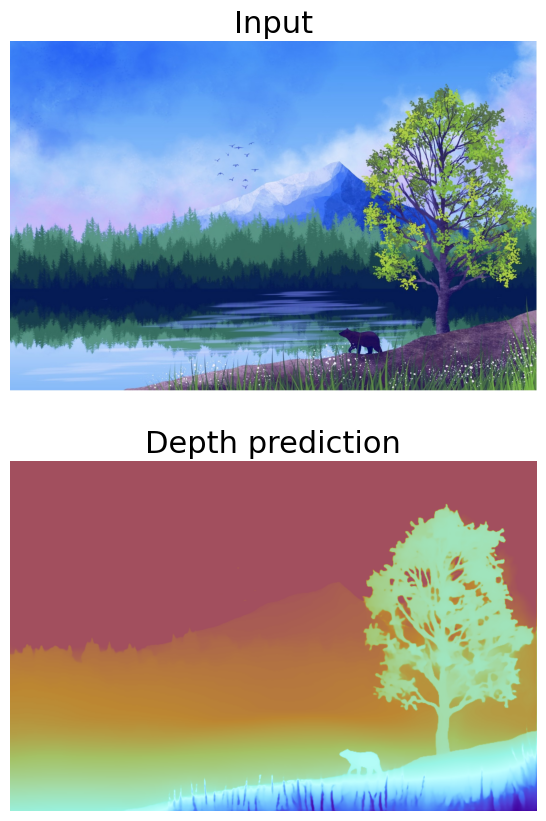

In [5]:
examples_path: pathlib.Path = pathlib.Path("./assets/examples")

images_lst: list[pathlib.Path] = list(examples_path.glob("*.jpg"))
image_num: int = random.randint(0, len(images_lst))
image = cv.imread(images_lst[image_num].__str__())[:, :, ::-1]

depth_raw = depth_anything.infer_image(image, input_size)
depth_raw = (depth_raw - depth_raw.min()) / (depth_raw.max() - depth_raw.min()) * 255.0
depth_uint8 = depth_raw.astype(np.uint8)

cmap = matplotlib.colormaps.get_cmap('Spectral_r')
depth_image = (cmap(depth_uint8)[:, :, :3] * 255)[:, :, ::-1].astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(depth_image)
plt.title("Depth prediction", fontsize=22)
plt.axis('off')

plt.show()